## pomegranate: fast and flexible probabilistic modelling

Author: Jacob Schreiber <br>
Contact: <jmschreiber91@gmail.com>

In [1]:
%matplotlib inline
import time
import pandas
import random
import numpy
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import itertools

from pomegranate import *

random.seed(0)
numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate

Fri Jan 10 2020 

numpy 1.18.1
scipy 1.4.1
pomegranate 0.12.0

compiler   : Clang 10.0.0 (clang-1000.11.45.5)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


pomegranate is a probabilistic modeling library for Python that aims to be easy to use, flexible, and fast. It is easy to use because it maintains a consistent and minimal API that mirrors the scikit-learn API when possible. It is flexible because it allows complicated probabilistic models to be built from simpler ones by easily stacking components on top of each other. It is fast due to its Cython backend which allows for fast numerics and multi-threading without cluttering the interface. pomegranate was developed at the University of Washington with the generous support from the following organizations:

<a href="https://escience.washington.edu/">
<img src="https://escience.washington.edu/wp-content/uploads/2015/10/eScience_Logo_HR.png" width="50%">
</a>

<a href="http://msdse.org/">
<img src="http://msdse.org/images/msdse.jpg" width="50%">
</a>

<a href="https://numfocus.org/">
<img src="https://numfocus.org/wp-content/uploads/2017/07/NumFocus_LRG.png" width="30%">
</a>

### The API

One of the core tenant of pomegranate is that everything is fundamentally a probability distribution and should be treated the same way. Most people are familiar with simple probability distributions such as the normal or the uniform distribution. However, a mixture of many simple distributions is still a probability distribution because the density under it still adds up to 1. A hidden Markov model is still a probability distribution over sequences because the probability of all potential sequences must add up to 1. A Bayesian network is literally a probability distribution that has been factorized along a graphical structure, with a discrete Bayesian network factorizing a very large joint probability table and a linear Gaussian Bayesian network factorizing a multivariate Gaussian distribution that has many 0's in the inverse covariance matrix.

A benefit of considering all methods as probability distributions is that it simplifies and unifies the API across all of the models. The common API is the following methods. Let's specify some distribution and take a look.

In [2]:
model = NormalDistribution(5, 1)

***model.probability(X)*** and ***model.log_probability(X)***

These methods return the probability of a single sample or a vector of probabilities if provided a vector of samples. This is equal to P(D|M) where D is the data and M is the model.

In [3]:
print(model.probability([4., 6., 7.]))
print(model.log_probability([4., 6., 7.]))

[0.24197072 0.24197072 0.05399097]
[-1.41893853 -1.41893853 -2.91893853]


***model.sample(n=1)***

This method will return a random sample from the probability distribution or a vector of random samples if n is set to be greater than 1.

In [4]:
model.sample(n=10)

array([6.76405235, 5.40015721, 5.97873798, 7.2408932 , 6.86755799,
       4.02272212, 5.95008842, 4.84864279, 4.89678115, 5.4105985 ])

***model.fit(X, weights=None, inertia=0.0, other arguments)***

This method will fit the distribution to the data. For simple distributions and Bayesian networks this corresponds to weighted maximum likelihood estimates. For other compositional distributions such as hidden Markov models this corresponds to an iterative expectation-maximization allgorithm. Optionally, weights can be provided for each of the samples. Different models will have different arguments that can be specified as well.

In [5]:
X = numpy.random.normal(7, 2, size=(100,))

model.fit(X)
model

{
    "class" :"Distribution",
    "name" :"NormalDistribution",
    "parameters" :[
        7.036955079959913,
        2.0668514243367655
    ],
    "frozen" :false
}

***model.summary(X, weights=None)***

This method implements the first part of the fitting process, which is summarizing a batch of data down to its sufficient statistics and storing them. These sufficient statistics are additive and will be updated for each successive batch that's seen. The sufficient statistics can be reset either through a call to `from_summaries` or a call to `clear_summaries`. 

In [6]:
X = numpy.random.normal(8, 1.5, size=(100,))

model.summarize(X)
model

{
    "class" :"Distribution",
    "name" :"NormalDistribution",
    "parameters" :[
        7.036955079959913,
        2.0668514243367655
    ],
    "frozen" :false
}

***model.from_summaries(inertia=0.0)***

This method implements the second part of the fitting process, which is using the stored sufficient statistics in order to update the model parameters.

In [7]:
model.from_summaries()
model

{
    "class" :"Distribution",
    "name" :"NormalDistribution",
    "parameters" :[
        8.068146018374335,
        1.4490322240381275
    ],
    "frozen" :false
}

***model.clear_summaries()***

This method resets the sufficient statistics stored to the model.

In [8]:
X = numpy.random.normal(3, 0.2, size=(100,))

model.summarize(X)
model.clear_summaries()
model.from_summaries()
model

{
    "class" :"Distribution",
    "name" :"NormalDistribution",
    "parameters" :[
        8.068146018374335,
        1.4490322240381275
    ],
    "frozen" :false
}

***Model.from_samples(distributions, n_components, X, weights=None)*** or ***Model.from_samples(X, weights=None)***

This class method will initialize and then fit the parameters of a model to some data. This differs from the `fit` function in that the `fit` function will update the parameters of a pre-defined model whereas the `from_samples` method will initialize a model to data and return the best parameters given the data.

In [9]:
X = numpy.random.normal(6, 1, size=(250, 1))

model = NormalDistribution.from_samples(X)
model

{
    "class" :"Distribution",
    "name" :"NormalDistribution",
    "parameters" :[
        5.878631757664192,
        1.0120288481111088
    ],
    "frozen" :false
}

In [10]:
model = GeneralMixtureModel.from_samples(NormalDistribution, 3, X)
model

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "NormalDistribution",
            "parameters" : [
                5.901815709887363,
                0.47865628749453537
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "NormalDistribution",
            "parameters" : [
                5.175959799664007,
                0.8774489898709738
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "NormalDistribution",
            "parameters" : [
                6.9902780582522634,
                0.597808757836137
            ],
            "frozen" : false
        }
    ],
    "weights" : [
        0.3148521575093671,
        0.42381846635660686,
        0.261329376134026
    ]
}

***model.to_json(separators=(',', ' :'), indent=4)***

This method returns the JSON serialization of the distribution as a string.

In [11]:
print(model.to_json())

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "NormalDistribution",
            "parameters" : [
                5.901815709887363,
                0.47865628749453537
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "NormalDistribution",
            "parameters" : [
                5.175959799664007,
                0.8774489898709738
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "NormalDistribution",
            "parameters" : [
                6.9902780582522634,
                0.597808757836137
            ],
            "frozen" : false
        }
    ],
    "weights" : [
        0.3148521575093671,
        0.42381846635660686,
        0.261329376134026
    ]
}


***Model.from_json(s)***

This class method returns the deserialization of the JSON string back to the model object. s can either be the JSON string or a filename ending in `.json` to read from.

In [12]:
model = NormalDistribution(5, 2)

model2 = Distribution.from_json(model.to_json())
model2

{
    "class" :"Distribution",
    "name" :"NormalDistribution",
    "parameters" :[
        5.0,
        2.0
    ],
    "frozen" :false
}

Compositional models, i.e., those that are not simple distributions, have three additional methods whose named are inspired by scikit-learn. These methods relate to the posterior probabilities P(M|D) of each of the components of the model given some data.

In [13]:
d1 = ExponentialDistribution(5.0)
d2 = ExponentialDistribution(0.3)

model = GeneralMixtureModel([d1, d2])
model

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "ExponentialDistribution",
            "parameters" : [
                5.0
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "ExponentialDistribution",
            "parameters" : [
                0.3
            ],
            "frozen" : false
        }
    ],
    "weights" : [
        0.5,
        0.5
    ]
}

***model.predict(X)***

This method returns the most likely component for each sample. In the case of a mixture model it returns the component that is most likely, in the case of a hidden Markov model it returns the most likely component for each observation in the sequence.

In [14]:
X = numpy.random.exponential(3, size=(10,1))

model.predict(X)

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 1], dtype=int32)

***model.predict_proba(X)***

This method returns the probability of each component for each sample. It is similar to the `predict` method except that it returns the probabilities instead of simply the most likely component.

In [15]:
model.predict_proba(X)

array([[0.00046883, 0.99953117],
       [0.74132615, 0.25867385],
       [0.58846532, 0.41153468],
       [0.89449455, 0.10550545],
       [0.        , 1.        ],
       [0.94041259, 0.05958741],
       [0.50991095, 0.49008905],
       [0.00002574, 0.99997426],
       [0.83434281, 0.16565719],
       [0.        , 1.        ]])

***model.predict_log_proba(X)***

Like predict_proba except that it returns the log probabilities instead of the probabilities.

In [16]:
model.predict_log_proba(X)

array([[ -7.66527111,  -0.00046894],
       [ -0.29931461,  -1.35218726],
       [ -0.53023729,  -0.88786198],
       [ -0.11149647,  -2.24899266],
       [-46.97709403,   0.        ],
       [ -0.06143657,  -2.820311  ],
       [ -0.67351918,  -0.71316817],
       [-10.56732239,  -0.00002574],
       [ -0.18111092,  -1.79783472],
       [-27.30692393,  -0.        ]])

### Flexibility

#### Modeling different features as different distributions

A second benefit of treating all models as probability distributions is that it greatly increases the flexibility that pomegranate provides. When people build naive Bayes classifiers, they typically will use a Gaussian distribution. However, there's no reason that one has to use a Gaussian distribution, you can drop in any type of distribution that you'd like. For example:

In [17]:
X = numpy.random.normal(5, 1, size=(100, 2))
X[50:] += 1

y = numpy.zeros(100)
y[50:] = 1

model1 = NaiveBayes.from_samples(NormalDistribution, X, y)
model2 = NaiveBayes.from_samples(LogNormalDistribution, X, y)

It is easy to drop in whatever probability distribution you'd like because it should be easy. Mathematically, the naive Bayes model relies on Bayes' rule, which says:

\begin{equation}
P(M|D) = \frac{P(D|M)P(M)}{P(D)}
\end{align}

Because the "naive" part of a "naive" Bayes model means that the model treats each feature independently, we can rewrite the $P(D|M)$ aspect as the product of these probabilities over all $d$ features:

\begin{equation}
P(M|D) = \frac{P(M) \prod\limits_{i=1}^{d} P(D_{i}|M)}{P(D)}
\end{equation}

Now, because each feature is independent, they can be modeled by different probability distributions.

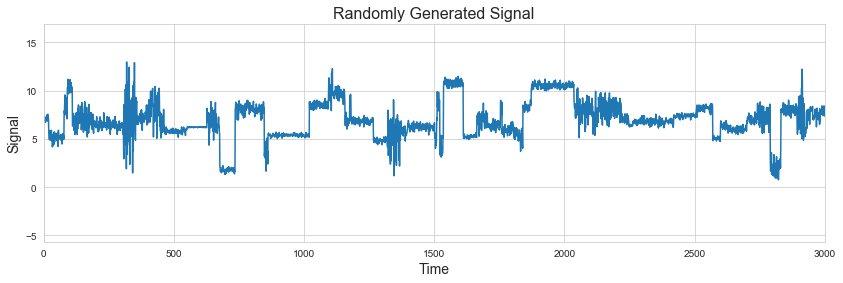

In [18]:
mu = numpy.random.normal(7, 2, size=1000)
std = numpy.random.lognormal(-0.8, 0.8, size=1000)
dur = numpy.random.exponential(50, size=1000)

data = numpy.concatenate([numpy.random.normal(mu_, std_, int(t)) for mu_, std_, t in zip(mu, std, dur)])

plt.figure(figsize=(14, 4))
plt.title("Randomly Generated Signal", fontsize=16)
plt.plot(data)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Signal", fontsize=14)
plt.xlim(0, 3000)
plt.show()

If someone was trying to model this signal, they could potentially try to segment it and then extract properties of those segments, such as the mean, the variance, and the duration. We can plot what thos would look like:

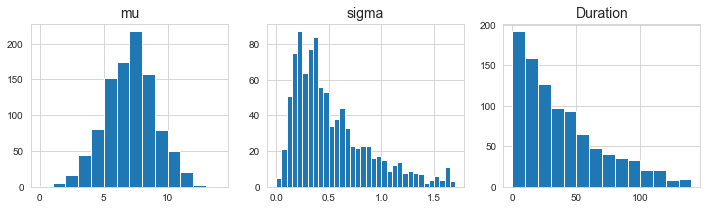

In [19]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("mu", fontsize=14)
plt.hist(mu, bins=numpy.arange(0, 15))

plt.subplot(132)
plt.title("sigma", fontsize=14)
plt.hist(std, bins=numpy.arange(0.00, 1.75, 0.05))

plt.subplot(133)
plt.title("Duration", fontsize=14)
plt.hist(dur, bins=numpy.arange(0, 150, 10))
plt.show()

We can see that the mean of the segments does have a Gaussian distribution, but that neither the standard deviation or the duration do. It would be suboptimal to assume all features were Gaussian, as a simple Gaussian naive Bayes model would. pomegranate allows you to define a different distribution for each feature, like the following:

In [20]:
X1 = numpy.array([numpy.random.normal(7, 2, size=400),
                  numpy.random.lognormal(-0.8, 0.8, size=400),
                  numpy.random.exponential(50, size=400)]).T

X2 = numpy.array([numpy.random.normal(8, 2, size=600),
                  numpy.random.lognormal(-1.2, 0.6, size=600),
                  numpy.random.exponential(100, size=600)]).T

X = numpy.concatenate([X1, X2])
y = numpy.zeros(1000)
y[400:] = 1

NaiveBayes.from_samples([NormalDistribution, LogNormalDistribution, ExponentialDistribution], X, y)

{
    "class" : "NaiveBayes",
    "models" : [
        {
            "class" : "Distribution",
            "name" : "IndependentComponentsDistribution",
            "parameters" : [
                [
                    {
                        "class" : "Distribution",
                        "name" : "NormalDistribution",
                        "parameters" : [
                            6.905835442537852,
                            2.09604452629164
                        ],
                        "frozen" : false
                    },
                    {
                        "class" : "Distribution",
                        "name" : "LogNormalDistribution",
                        "parameters" : [
                            -0.880499005246798,
                            0.7642112111076668
                        ],
                        "frozen" : false
                    },
                    {
                        "class" : "Distribution",
                    

Modeling each feature independently is allowed for naive Bayes, mixtures, and hidden Markov models. This is very useful when trying to capture different dynamics in different features.

#### Stacking models on top of each other

Next, another feature that emerges when you treat all models as probability distributions is that they can be easily stacked within each other. For example, if a mixture is just a probability distribution, then naturally you should be able to make a mixture Bayes classifier by dropping a `GeneralMixtureModel` into a `BayesClassifier` just as easily as a Gaussian Bayes classifier by dropping a `MultivariateGaussianDistribution` into the `BayesClassifier`.

In [23]:
X = numpy.concatenate([numpy.random.normal((5, 1), 1, size=(200, 2)),
                       numpy.random.normal((6, 4), 1, size=(200, 2)),
                       numpy.random.normal((3, 5), 1, size=(350, 2)),
                       numpy.random.normal((7, 6), 1, size=(250, 2))])

y = numpy.zeros(1000)
y[400:] = 1

model = BayesClassifier.from_samples(MultivariateGaussianDistribution, X, y)
print(model.log_probability(X).sum())


d1 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X[y == 0])
d2 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X[y == 1])
model2 = BayesClassifier([d1, d2], [0.4, 0.6])
print(model2.log_probability(X).sum())

-4012.4121095570604
-3904.723017794966


In this case we build data that intentionally has 4 clusters, of which each class is composed of two of the clusters. A simple normal distribution is unlikely to capture this well, but a mixture model is built specifically to model distributions that are composed of multiple parts. We can see that the correspond log probability is much higher when we incorporate the mixture model in. There is an implementation detail that doesn't allow you yet to pass in a compositional model into the `from_samples` method quite yet, but in this case it is fairly simple to break up the data such that we build the model ourselves.

### Speed

pomegranate uses a Cython backend for the computationally intensive aspects of the calculation, both dramatically speeding up calculations and allowing for multithreading to be utilized.

#### numpy

pomegranate used to be consistently faster than numpy at fitting probability distributions to data, when compared to performing the same operations in numpy. However, due to consistent improvements in numpy, it is now a more complicated picture. For example, let's look at fitting a normal distribution to 1,000 samples.

In [24]:
X = numpy.random.normal(4, 1, size=1000)

%timeit -n 1 -r 1 numpy.mean(X), numpy.std(X)
%timeit -n 1 -r 1 NormalDistribution.from_samples(X)

152 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
336 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


pomegranate appears to be a bit faster, but the total amount of time is negligble one way or another. If we increase the size of the data we're using to 10 million samples:

In [25]:
X = numpy.random.normal(4, 1, size=10000000)

%timeit numpy.mean(X), numpy.std(X)
%timeit NormalDistribution.from_samples(X)

52.9 ms ± 903 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
67.8 ms ± 577 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It looks like pomegranate is more comparable to numpy.

Let's now look at fitting a multivariate Gaussian distribution. The calculation of a covariance matrix requires a dot product, which numpy accelerates using BLAS. pomegranate uses a Cython wrapper of BLAS and so can take advantage of those speed improvements. Let's look at fitting to one million data points with 3 dimensions.

In [26]:
X = numpy.random.normal(4, 1, size=(1000000, 3))

%timeit numpy.mean(X, axis=0), numpy.cov(X, rowvar=False, ddof=0)
%timeit MultivariateGaussianDistribution.from_samples(X)

51.2 ms ± 838 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
33.2 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It looks like pomegranate is around the same speed here. However, if we fit to a 1000 dimensional sample rather than a 3 dimensional one:

In [27]:
X = numpy.random.normal(4, 1, size=(100000, 1000))

%timeit numpy.mean(X, axis=0), numpy.cov(X, rowvar=False, ddof=0)
%timeit MultivariateGaussianDistribution.from_samples(X)

2.45 s ± 76.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.99 s ± 612 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now it looks like pomegranate is slower than numpy.

The main take-away when compared to numpy is that pomegranate and numpy appear to perform similarly. As the samples become larger numpy becomes faster than pomegranate, but they're both within an order of magnitude of each other one way or another. If you're trying to do basic operations on a large amount of data, you may want to stick with using numpy.

#### scipy

scipy can be used to calculate probabilities of samples given a distribution. This corresponds to the `probability` and `log_probability` functions in pomegranate. Let's see how long it takes to calculate these probabilities in the two packages given a normal distrubution.

In [29]:
from scipy.stats import norm

d = NormalDistribution(0, 1)
x = numpy.random.normal(0, 1, size=(10000000,))

%timeit norm.logpdf(x, 0, 1)
%timeit NormalDistribution(0, 1).log_probability(x)

print("\nlogp difference: {}".format((norm.logpdf(x, 0, 1) - NormalDistribution(0, 1).log_probability(x)).sum()))

581 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
47.2 ms ± 883 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

logp difference: -3.990151116406437e-06


Looks like it can be significantly faster. Let's also look at a large multivariate normal distribution with 2500 dimensions.

In [30]:
from scipy.stats import multivariate_normal

dim = 2500
n = 1000

mu = numpy.random.normal(6, 1, size=dim)
cov = numpy.eye(dim)

X = numpy.random.normal(8, 1, size=(n, dim))

d = MultivariateGaussianDistribution(mu, cov)

%timeit multivariate_normal.logpdf(X, mu, cov)
%timeit MultivariateGaussianDistribution(mu, cov).log_probability(X)
%timeit d.log_probability(X)

print("\nlogp difference: {}".format((multivariate_normal.logpdf(X, mu, cov) - d.log_probability(X)).sum()))

3.39 s ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
796 ms ± 6.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
171 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

logp difference: 8.183596946764737e-07


One of the reasons which pomegranate can be so fast at calculating log probabilities is that it is able to cache parts of the logpdf equation so that it doesn't need to do all of the calculations each time. For example, let's look at the Normal distribution pdf equation:

\begin{equation}
P(X|\mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma} exp \left( -\frac{(x - \mu)^{2}}{2\sigma^{2}} \right) \\
\end{equation}

We can take the log of this to simplify it.

\begin{equation}
logP(X|\mu, \sigma) = -\log \left(\sqrt{2\pi}\sigma \right) - \frac{(x-\mu)^{2}}{2\sigma^{2}}
\end{equation}

pomegranate speeds up this calculation by caching $-\log(\sqrt{2\pi}\sigma)$ and $2\sigma^{2}$ when the object is created. This means that the equation is simplified to the following:

\begin{equation}
logP(X|\mu, \sigma) = \alpha - \frac{(x - \mu)^{2}}{\beta}
\end{equation}

We don't need to calculate any logs or exponentials here, just a difference, a multiplication, a division, and a subtraction.

#### scikit-learn

scikit-learn and pomegranate overlap when it comes to naive Bayes classifiers and mixture models. In pomegranate, both of these model types can be used with any distribution, allowing mixtures of exponentials or log-normals to be made just as easily as mixtures of Gaussians, whereas in scikit-learn only Gaussians or multinomials are allowed. Let's compare speed of the overlap.

In [33]:
from sklearn.mixture import GaussianMixture

X = numpy.random.normal(8, 1, size=(10000, 100))

%timeit model1 = GaussianMixture(5, max_iter=10).fit(X)
%timeit model2 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 5, X, max_iterations=10)

/Users/ksachdeva/Desktop/Dev/myoss/pomegranate/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/ksachdeva/Desktop/Dev/myoss/pomegranate/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/ksachdeva/Desktop/Dev/myoss/pomegranate/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/ksachdeva/Desktop/Dev/myoss/pomegranate/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initializa

1.79 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.43 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It looks like the two are approximately the same speed on a single thread. Let's look at naive Bayes now.

In [34]:
from sklearn.naive_bayes import GaussianNB

X = numpy.random.normal(8, 1, size=(100000, 500))
X[:50000] += 1

y = numpy.zeros(100000)
y[:50000] = 1

%timeit GaussianNB().fit(X, y)
%timeit NaiveBayes.from_samples(NormalDistribution, X, y)

1.14 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.37 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It looks like scikit-learn is a bit faster when it comes to training a Gaussian naive Bayes model. 

Much like with the comparisons to numpy, if scikit-learn has something easily implemented, it's likely better to try to use their implementation. The goal of pomegranate is not to step on the feet of these other packages, but rather to provide similarly-fast implementations that extend to other probability distributions. For example, you can train a log normal naive Bayes in the following manner:

In [35]:
model = NaiveBayes.from_samples(LogNormalDistribution, X, y)

No such functionality yet exists in scikit-learn to train naive Bayes models for arbitrary distributions.